In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
player_data = pd.read_csv("DataCollection/Player_Stats/player_stats_2021-22.csv")
shooting_data = pd.read_csv("DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2021-22.csv")

In [3]:
shooting_data.columns = ["Player", "Pos", "Age", "Tm", "G", "MP", "FG%", "AvgDistance", "2PAr",
                         "0-3Ar", "3-10Ar", "10-16Ar", "16-3PAr", "3PAr", "2P%", "0-3%", "3-10%", "10-16%",
                         "16-3P%", "3P%", "2P_Assisted", "3P_Assisted", "DunksAr", "Dunks", "3PCornerAr", "3PCorner%",
                         "HeavesAttempted", "Heaves"]

In [4]:
player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

In [5]:
player_data = player_data.fillna(0)
player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
player_data = player_data.sort_values(by=['G'], ascending=False)
player_data = player_data[player_data["Tm"] != "TOT"]
player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
player_data.reset_index(inplace=True)
player_data.drop(columns=['index'], inplace=True)

In [6]:
features = player_data.loc[:, ~player_data.columns.isin(["Player", "Pos", "Tm"])]
target = player_data['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

In [12]:
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [15]:
best_rf = rand_search.best_estimator_
rand_search.best_params_

{'max_depth': 3, 'n_estimators': 388}

In [16]:
y_pred = best_rf.predict(X_test)


Bad key text.latex.preview in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mathe\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

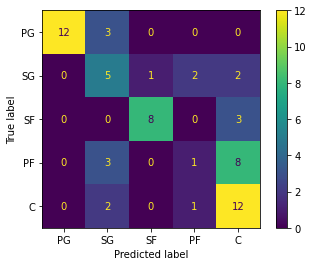

In [19]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, ["PG", "SG", "SF", "PF", "C"]).plot()

In [21]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(accuract, precision, recall)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

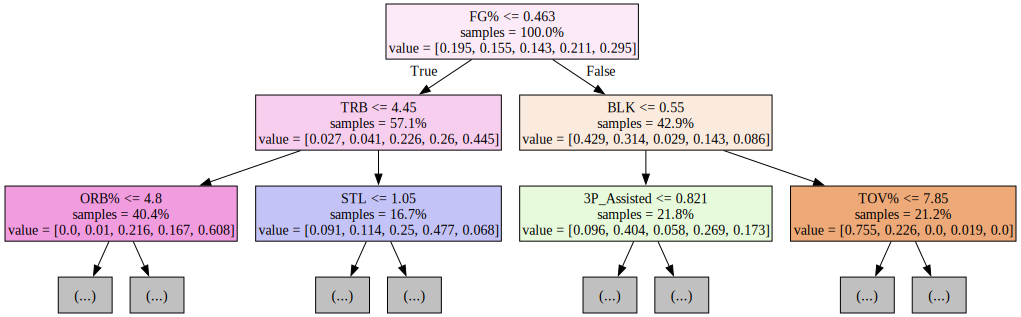

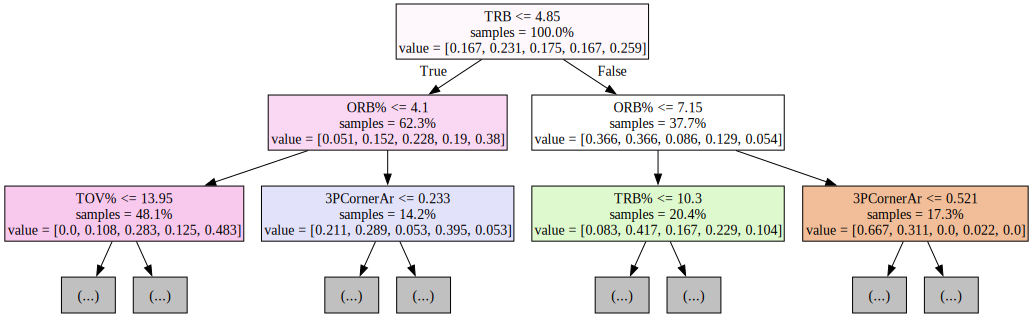

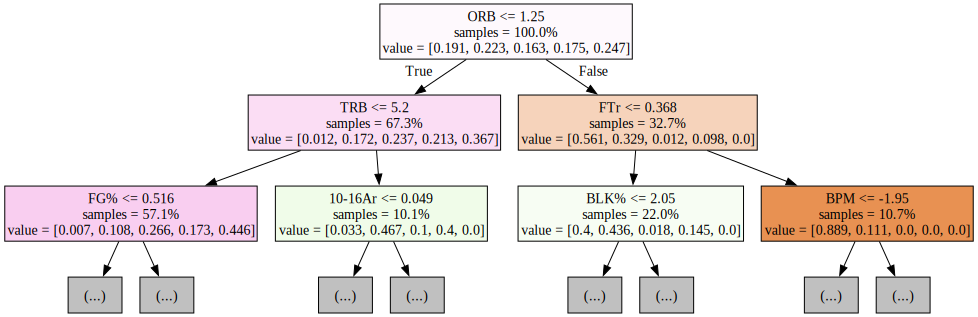

In [10]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)